# STANDARD Method with Celltypist

We performed analysis following three scenarions:
1. scGPT reference mapping
2. scGPT finetuned with GSE242423 dataset
3. standard method
    1. **standard method with celltypist only <---- YOU ARE HERE**
    2. with celltypist + scANVI

# Description
- we performed cell type annotation prediction using the labels from GSE242423:
    - Extreme OSK (xOSK)    
    - Fibroblast            
    - Fibroblast-like      
    - High OSK (hOSK)        
    - Intermediate         
    - Keratinocyte-like     
    - Partial                
    - Pre-iPSC              
    - iPSC

# Objective
- In this jupyter notebook we only perform cell type annotation using celltypist on the validation dataset, which contains 30% of the GSE242423.
- We calculate evaluation metrics (NMI, ARI, Accuracy, Confusion matrix) using SCIB first, and SKLEARN later.

# Import libraries

In [18]:
import celltypist
import scanpy as sc
import os
import pandas as pd
import scib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scvi
from collections import Counter
import anndata
from celltypist import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score, accuracy_score, normalized_mutual_info_score

# Load reprogramming reference dataset GSE242423

In [19]:

# Load your data (assuming it's in AnnData format)
adata = anndata.read_h5ad("../../REPROGRAMMING_DATASETS/reprogramming.h5ad")
# filtering genes
sc.pp.filter_genes(adata, min_cells = 10)
sc.pp.normalize_total(adata, target_sum = 1e4) #Note this is only for cell annotation, recommended by authors but not best
sc.pp.log1p(adata)

In [20]:
adata.obs.groupby('celltype').size()

/tmp/ipykernel_15354/472626278.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('celltype').size()


celltype
Extreme OSK (xOSK)     1707
Fibroblast            11041
Fibroblast-like       16916
High OSK (hOSK)         523
Intermediate          12271
Keratinocyte-like       934
Partial                4445
Pre-iPSC               8416
iPSC                   3125
dtype: int64

# Divide dataset in training (70%) and validation (30%)

In [21]:
# Get cell indices for stratified split
cell_indices = np.arange(adata.n_obs)
train_indices, val_indices = train_test_split(
    cell_indices, 
    test_size=0.3, 
    stratify=adata.obs['celltype'], 
    random_state=42
)


# Create train and validation AnnData objects
train_adata = adata[train_indices]
val_adata = adata[val_indices]


# Use Cell typist to predict cell type annotation

In [22]:
# Train the model on the training set
train_model = celltypist.train(train_adata, labels='celltype', n_jobs=22,
                               use_SGD=False,
                               feature_selection=True, top_genes=300)

# Use the trained model to predict cell types on the validation set
val_predictions = celltypist.annotate(val_adata, model=train_model)


🍳 Preparing data before training
🔬 Input data has 41564 cells and 25039 genes
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 1594 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
/home/ubuntu/miniconda3/envs/scgpt/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
✅ Model training done!
🔬 Input data has 17814 cells and 25039 genes
🔗 Matching reference genes in the model
🧬 1594 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


# Save train model (to not train again) 

In [23]:
train_model.write('reference_reprogramming_new.pkl')

In [24]:
train_model = models.Model.load('reference_reprogramming_new.pkl')


# Analyze cell distribution in validation set by batch

In [25]:
val_adata.obs.groupby('sample').size()

/tmp/ipykernel_15354/429429014.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val_adata.obs.groupby('sample').size()


sample
D0      2902
D2       804
D4      1592
D6      2391
D8      1656
D10     3120
D12     2145
D14     2266
iPSC     938
dtype: int64

# Calculate metrics using SCIB

In [26]:
import celltypist
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scib
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def evaluate_celltypist(adata, model, batch_key=None, label_key='celltype', notes=None, predictions=None):
    
    # Add predicted labels to the AnnData object
    adata.obs['predicted_celltype'] = predictions.predicted_labels
    
    # Ensure we have PCA coordinates
    if 'X_pca' not in adata.obsm_keys():
        logger.info("Computing PCA...")
        sc.pp.pca(adata)
    
    # Calculate metrics
    results = scib.metrics.metrics(
        adata,
        adata_int=adata,
        batch_key=batch_key,
        label_key=label_key,
        embed="X_pca",
        isolated_labels_asw_=False,
        silhouette_=True,
        hvg_score_=False,
        graph_conn_=True,
        pcr_=True,
        isolated_labels_f1_=False,
        trajectory_=False,
        nmi_=True,
        ari_=True,
        cell_cycle_=False,
        kBET_=False,
        ilisi_=False,
        clisi_=False,
    )

    if notes is not None:
        logger.info(f"{notes}")

    logger.info(f"{results}")

    result_dict = results[0].to_dict()
    logger.info(
        "Biological Conservation Metrics: \n"
        f"ASW (cell-type): {result_dict.get('ASW_label', 'N/A'):.4f}, "
        f"graph cLISI: {result_dict.get('cLISI', 'N/A'):.4f}, "
        f"isolated label silhouette: {result_dict.get('isolated_label_silhouette', 'N/A'):.4f}, \n"
        "Batch Effect Removal Metrics: \n"
        f"PCR_batch: {result_dict.get('PCR_batch', 'N/A'):.4f}, "
        f"ASW (batch): {result_dict.get('ASW_label/batch', 'N/A'):.4f}, "
        f"graph connectivity: {result_dict.get('graph_conn', 'N/A'):.4f}, "
        f"graph iLISI: {result_dict.get('iLISI', 'N/A'):.4f}"
    )

    result_dict["avg_bio"] = np.mean([
        result_dict.get("NMI_cluster/label", 0),
        result_dict.get("ARI_cluster/label", 0),
        result_dict.get("ASW_label", 0)
    ])

    # Remove nan values in result_dict
    result_dict = {k: v for k, v in result_dict.items() if not np.isnan(v)}

    return result_dict

In [27]:
evaluation_results = evaluate_celltypist(adata, train_model, batch_key='sample', label_key='celltype', notes="CellTypist Evaluation", predictions=val_predictions)


/home/ubuntu/miniconda3/envs/scgpt/lib/python3.10/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
adata_int:  AnnData object with n_obs × n_vars = 59378 × 25039
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'percent.oskm', 'umap1', 'umap2', 'barcode_sample', 'celltype', 'n_genes', 'predicted_celltype', 'cluster'
    var: 'n_cells'
    uns: 'neighbors', 'pca', 'umap', 'log1p', 'cluster'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'
cluster_key:  cluster
label_key:  celltype
implementation of nmi_method:  arithmetic
nmi dir:  None
ARI...
Silhouette score...
PC regression...
A_DATA:  AnnData object with n_obs × n_vars = 59378 × 25039
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'percent.oskm', 'umap1', 'umap2', 'barcode_sample', 'celltype', 'n_genes', 'predicted_celltype', 'cluster'
    var: 'n_cells'
    uns: 'neighbors', 'pca', 'umap', 'log1p', 'cluster'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'
A_DATA:  AnnData object with n_obs × n_vars = 59378 × 25039
    obs: 'nCount_RNA', 'nFeature_RNA', '

/home/ubuntu/miniconda3/envs/scgpt/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


covariate: sample
EMBED:  None
compute PCA n_comps: 50


/home/ubuntu/miniconda3/envs/scgpt/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/home/ubuntu/miniconda3/envs/scgpt/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/home/ubuntu/miniconda3/envs/scgpt/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/home/ubuntu/miniconda3/envs/scgpt/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: Futu

Graph connectivity...


# Checking evaluation metrics from SCIB

In [28]:
evaluation_results

{'NMI_cluster/label': 0.7182322926135647,
 'ARI_cluster/label': 0.6123804296614206,
 'ASW_label': 0.5675603577414673,
 'ASW_label/batch': 0.8681756029543573,
 'PCR_batch': 0.0,
 'graph_conn': 0.9954365262762038,
 'avg_bio': 0.6327243600054842}

# Using SKLEARN to evaluate metrics (ARI, NMI, Accuracy)

In [55]:
# Extract the predicted labels and ensure they are 1D
predicted_labels = val_predictions.predicted_labels.values.flatten()
# Calculate metrics
ari = adjusted_rand_score(val_adata.obs['celltype'], predicted_labels)
accuracy = accuracy_score(val_adata.obs['celltype'], predicted_labels)
nmi = normalized_mutual_info_score(val_adata.obs['celltype'], predicted_labels)

print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Normalized Mutual Information: {nmi:.4f}")

Adjusted Rand Index: 0.8815
Accuracy: 0.9400
Normalized Mutual Information: 0.8415


# Data visualization

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
... storing 'predicted_celltype' as categorical


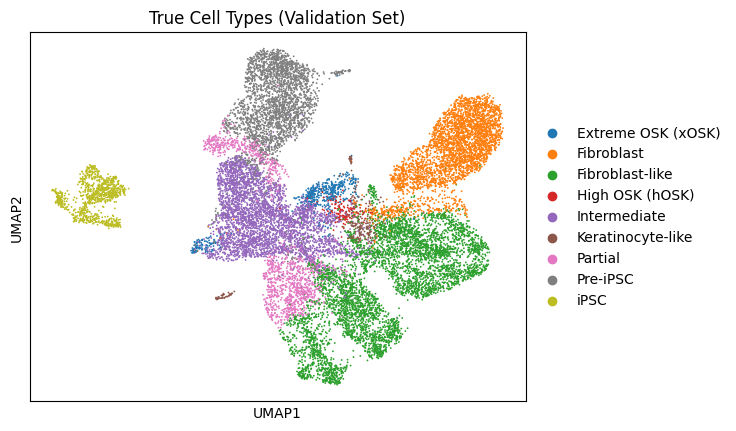

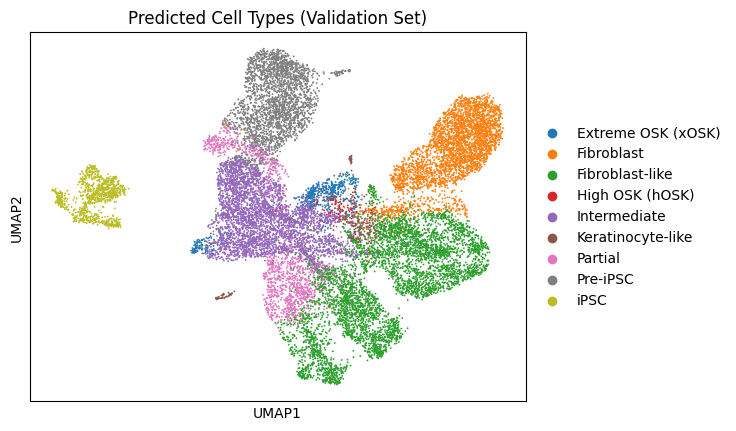

In [10]:
# Add predicted labels to the validation AnnData object
val_adata.obs['predicted_celltype'] = predicted_labels

# Visualizations

# 1. UMAP plot of true labels
sc.pp.neighbors(val_adata)
sc.tl.umap(val_adata)
sc.pl.umap(val_adata, color='celltype', title='True Cell Types (Validation Set)')

# 2. UMAP plot of predicted labels
sc.pl.umap(val_adata, color='predicted_celltype', title='Predicted Cell Types (Validation Set)')


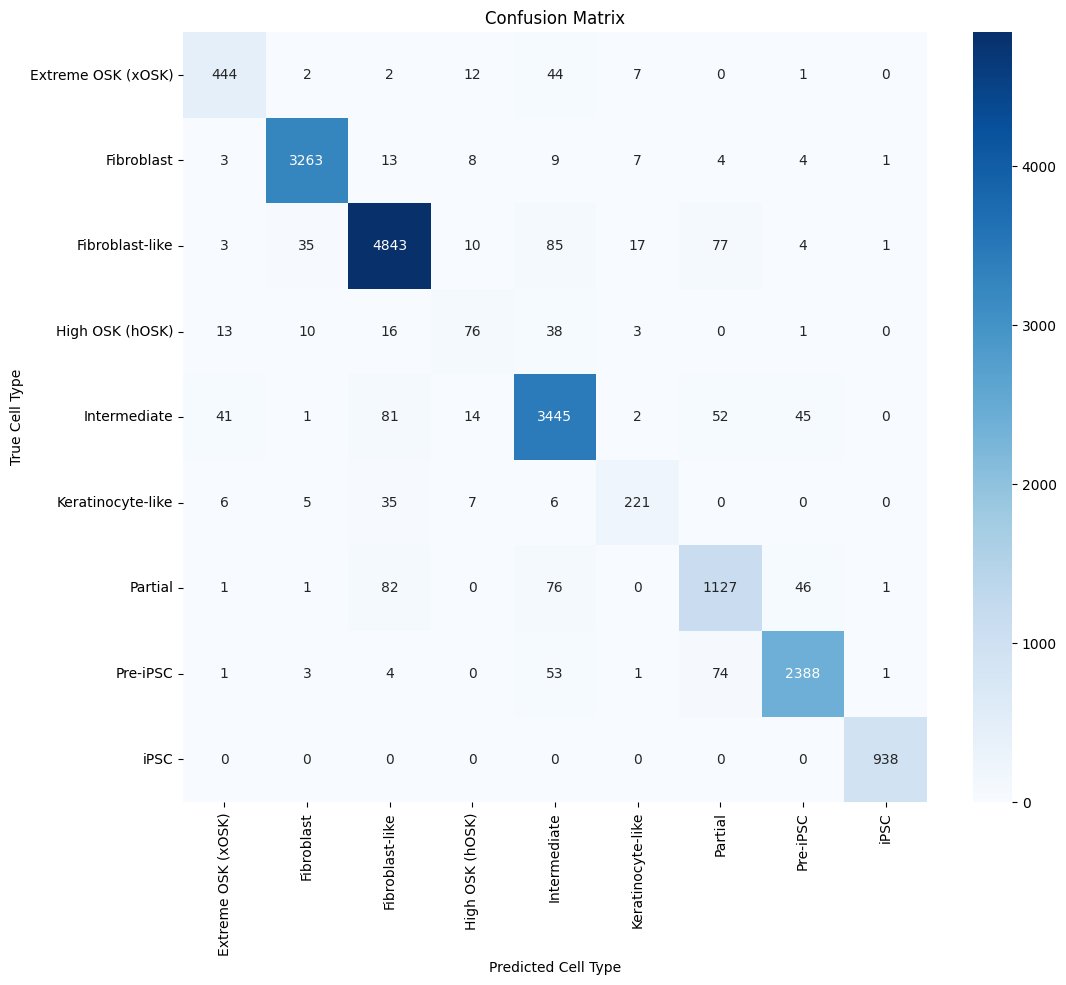

In [11]:

# 3. Confusion matrix
conf_matrix = pd.crosstab(val_adata.obs['celltype'], val_adata.obs['predicted_celltype'])
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Cell Type')
plt.ylabel('True Cell Type')
plt.show()


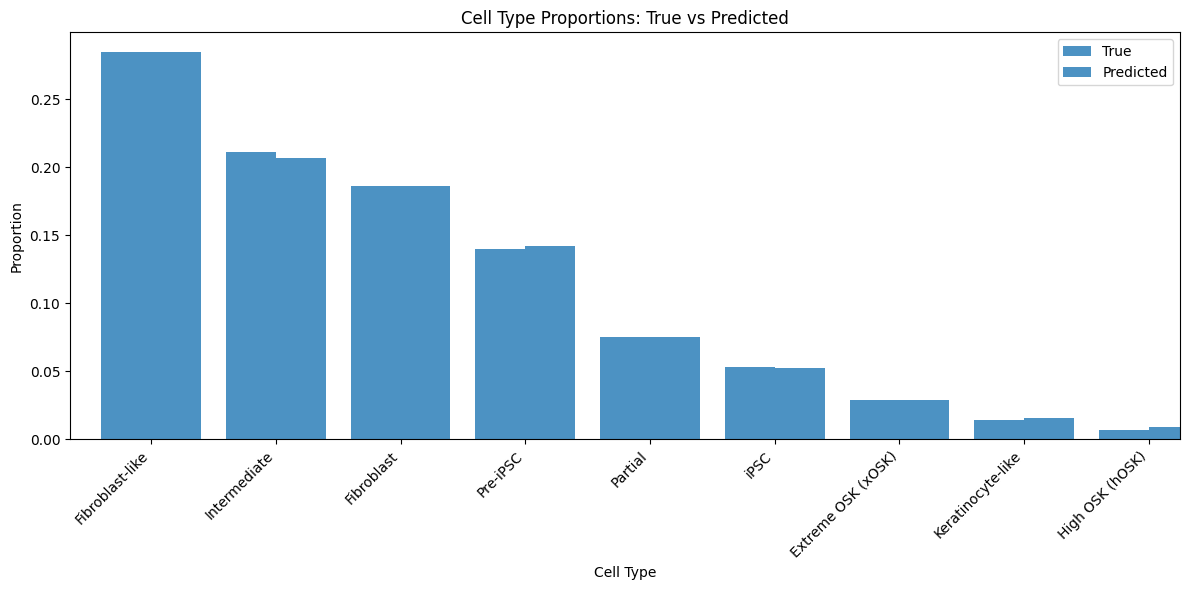

In [12]:

# 4. Bar plot of cell type proportions
true_proportions = val_adata.obs['celltype'].value_counts(normalize=True)
predicted_proportions = val_adata.obs['predicted_celltype'].value_counts(normalize=True)

plt.figure(figsize=(12, 6))
true_proportions.plot(kind='bar', position=0, width=0.4, alpha=0.8, label='True')
predicted_proportions.plot(kind='bar', position=1, width=0.4, alpha=0.8, label='Predicted')
plt.title('Cell Type Proportions: True vs Predicted')
plt.xlabel('Cell Type')
plt.ylabel('Proportion')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


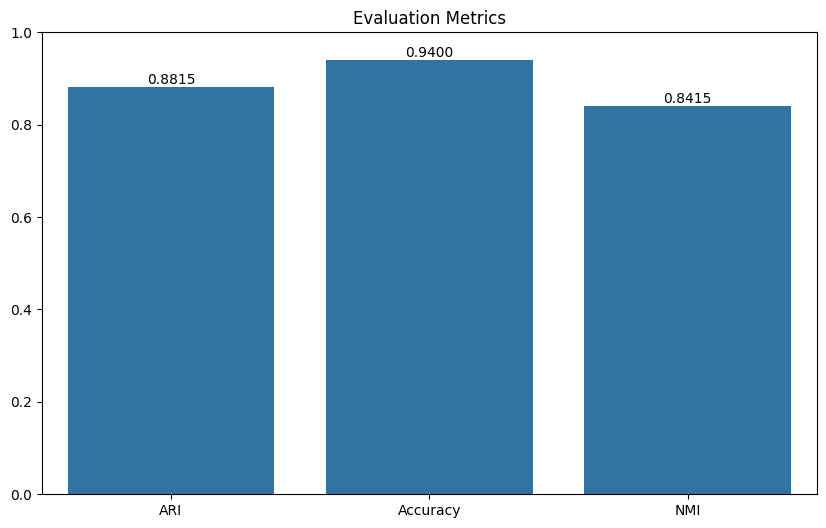

In [19]:

# 6. Metrics visualization
metrics = ['ARI', 'Accuracy', 'NMI']
scores = [ari, accuracy, nmi]

plt.figure(figsize=(10, 6))
sns.barplot(x=metrics, y=scores)
plt.title('Evaluation Metrics')
plt.ylim(0, 1)
for i, score in enumerate(scores):
    plt.text(i, score, f'{score:.4f}', ha='center', va='bottom')
plt.show()